In [1]:
!pip install keras 
!pip install git+https://github.com/qubvel/segmentation_models
!git clone https://github.com/SlinkoIgor/ImageDataAugmentor.git

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-tlvwr4_4
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-tlvwr4_4
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33794 sha256=56e3527c0b95dcf617a9e63dfdcfab6242f421d1d4cd9318f29b5248a3060d14
  Stored in directory: /tmp/pip-ephem-wheel-cache-jxz4063q/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Cloning into 'ImageDataAugmentor'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 310 (delta

In [2]:
import os
patchsize = 256

# Training data
x_train_dir = '../input/covid19/COVID-19/train/images/'
y_train_dir = '../input/covid19/COVID-19/train/masks/'

# Validation data
x_valid_dir = '../input/covid19/COVID-19/test/images/'
y_valid_dir = '../input/covid19/COVID-19/test/masks/'

print("Training and validation samples: ", len(os.listdir(x_train_dir)), len(os.listdir(x_valid_dir)))

Training and validation samples:  3229 249


In [3]:
import random
import numpy as np

# Load a random image from the images folder
image_fns = sorted(next(os.walk(x_train_dir))[2])
gt_fns = sorted(next(os.walk(y_train_dir))[2])
print(image_fns[:3], gt_fns[:3])

# Get random number
idx = random.randrange(len(image_fns))
print("Index: ", idx)

import skimage
from skimage import io
# Read image and mask
image = io.imread(os.path.join(x_train_dir, image_fns[idx]))
gt = io.imread(os.path.join(y_train_dir, gt_fns[idx]))

print(image.shape, gt.shape)

val1 = gt.flatten()
print("Ground truth classes: ", np.unique(val1))

['coronacases_001.ni_z001.png', 'coronacases_001.ni_z002.png', 'coronacases_001.ni_z003.png'] ['coronacases_001.ni_z001.png', 'coronacases_001.ni_z002.png', 'coronacases_001.ni_z003.png']
Index:  584
(384, 384) (384, 384)
Ground truth classes:  [0 1 2 3]


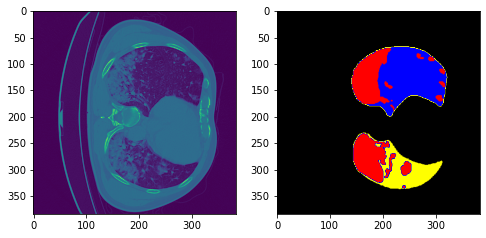

In [4]:
import matplotlib.colors
import matplotlib.pyplot as plt
norm=plt.Normalize(0,3) # 4 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","yellow","blue","red"])

f, axarr = plt.subplots(1,2, figsize=(8,8))

axarr[0].imshow(image)
axarr[1].imshow(gt, cmap =map_name, norm=norm)


# Visualization Function

In [5]:

# Helper function for data visualization
def visualize(**images):
    norm=plt.Normalize(0,3) 
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","yellow","blue","red"])
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=map_name, norm=norm)
    plt.show()

#Augmentation 

In [6]:
import tensorflow

import albumentations
import cv2

SOURCE_SIZE = 384
TARGET_SIZE = 384

train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE), 
                                   TARGET_SIZE, 
                                   TARGET_SIZE, 
                                   interpolation=cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),

])

val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

# Dataset Class

In [7]:
# Classes for data loading and preprocessing
class Dataset:
    """Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['RightLung', 'LeftLung', 'Disease', 'Background']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        
        self.images_fps = sorted([os.path.join(images_dir, image_id) for image_id in self.ids])
        self.masks_fps = sorted([os.path.join(masks_dir, image_id) for image_id in self.ids])

        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls) for cls in classes] # cls used instead of cls.lower()

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # Read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_fps[i], 0)
        
        # Extract certain classes from mask
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # Add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # Apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

# Dataloder class

In [8]:
import keras
class Dataloder(keras.utils.Sequence):
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # Transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

Using TensorFlow backend.


(384, 384, 3) (384, 384, 4)


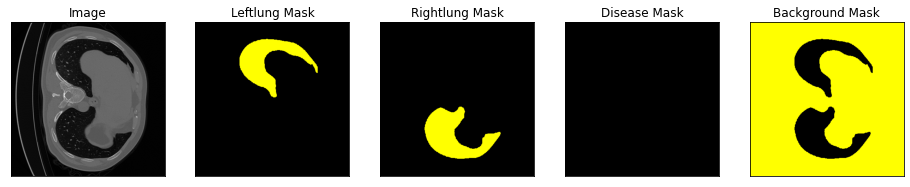

(384, 384, 3) (384, 384, 4)


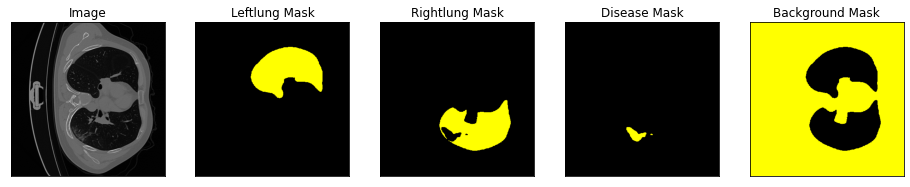

(384, 384, 3) (384, 384, 4)


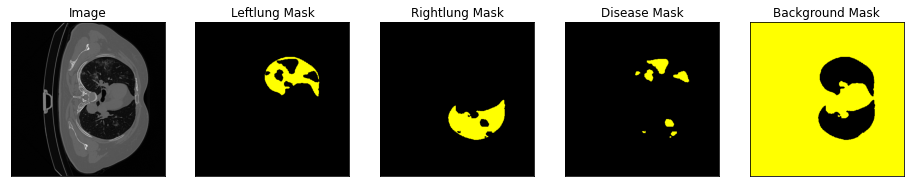

(384, 384, 3) (384, 384, 4)


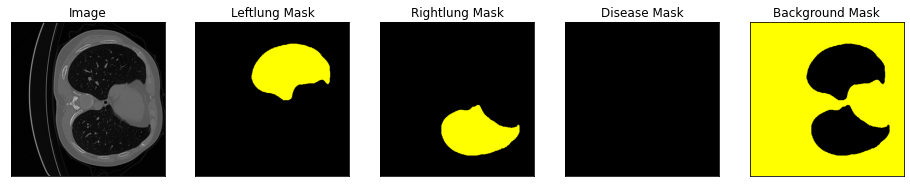

(384, 384, 3) (384, 384, 4)


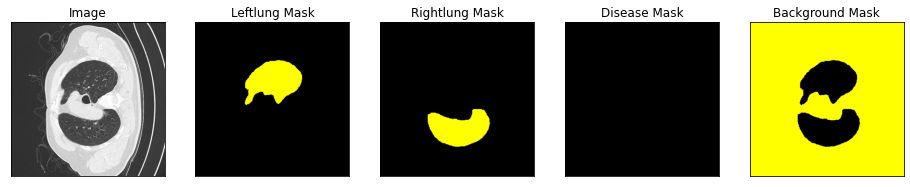

In [9]:
import cv2

med= ['RightLung', 'LeftLung', 'Disease']

dataset = Dataset(x_train_dir, y_train_dir, classes=med)

for i in range(5):
    
    image, mask = dataset[random.randrange(len(dataset))] # get some sample
    print(image.shape, mask.shape)
    
    visualize(
    image=image, 
    LeftLung_mask= mask[..., 2].squeeze(),
    RightLung_mask= mask[..., 1].squeeze(),
    Disease_mask= mask[..., 3].squeeze(),
    background_mask= mask[..., 0].squeeze(),
    )

In [10]:
n_classes=4
CLASSES=med
train_dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES,augmentation=train_augs)
valid_dataset = Dataset(x_valid_dir, y_valid_dir, classes=CLASSES, augmentation=val_augs)

(384, 384, 3) (384, 384, 4)


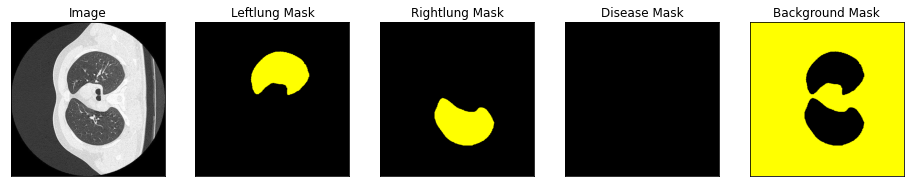

(384, 384, 3) (384, 384, 4)


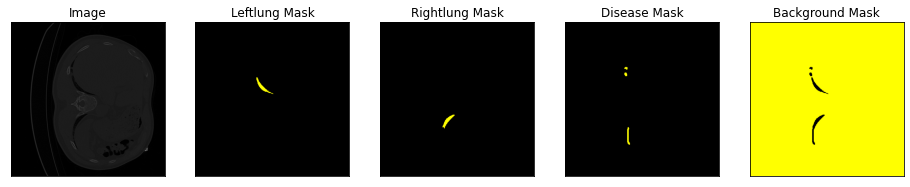

(384, 384, 3) (384, 384, 4)


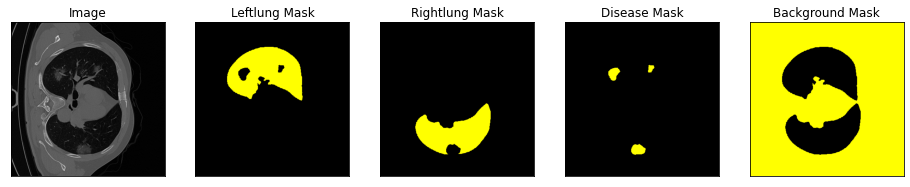

In [11]:
for i in range(3):
    
    image, mask = dataset[random.randrange(len(train_dataset))] 
    print(image.shape, mask.shape)
    
    visualize(
    image=image, 
    LeftLung_mask= mask[..., 2].squeeze(),
    RightLung_mask= mask[..., 1].squeeze(),
    Disease_mask= mask[..., 3].squeeze(),
    background_mask= mask[..., 0].squeeze(),
    )

In [12]:
BATCH_SIZE=16
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
images,labels=next(iter(train_dataloader))
print(images.shape, labels.shape)

(16, 384, 384, 3) (16, 384, 384, 4)


In [13]:
BATCH_SIZE=16
EPOCHS=100
valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
x , y = next(iter(valid_dataloader))
print(x.shape, y.shape)

(16, 384, 384, 3) (16, 384, 384, 4)


# F1_score Function

In [14]:
def fscore_background(y_true, y_pred):
    return sm.metrics.f1_score(y_true[..., 0:1], 
                               y_pred[..., 0:1])
    
def fscore_leftlung(y_true, y_pred):
    return sm.metrics.f1_score(y_true[..., 1:2], 
                               y_pred[..., 1:2])

def fscore_rightlung(y_true, y_pred):
    return sm.metrics.f1_score(y_true[..., 2:3], 
                               y_pred[..., 2:3])

def fscore_disease(y_true, y_pred):
    return sm.metrics.f1_score(y_true[..., 3:4], 
                               y_pred[..., 3:4])

#Dice Function

In [15]:
from keras import backend as K
def Dice_coef(y_true, y_pred, smooth = 1):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
 
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def Dice_loss(y_true, y_pred):   
    return  1.0 - Dice_coef(y_true, y_pred) 
    

# PSPNET Model

In [16]:
from segmentation_models import Unet, Linknet, FPN, PSPNet
import segmentation_models as sm

from keras.layers import Input, Conv2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
np.random.seed(0)

base_model = PSPNet(backbone_name='efficientnetb0',
                  encoder_weights='imagenet',
                  classes=4, 
                  activation='softmax')

Segmentation Models: using `keras` framework.
16809984/16804768 [==============================] - 1s 0us/step


In [17]:
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 192, 192, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 192, 192, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 192, 192, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [18]:
# from keras.models import Model
# inp = Input(shape=(256, 256, 3))
# l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
# out = base_model(l1)

model = base_model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 192, 192, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 192, 192, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 192, 192, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [19]:
model.compile(Adam(learning_rate=0.001, amsgrad=True),
              loss=sm.losses.categorical_crossentropy,
              metrics=[fscore_background, fscore_leftlung, fscore_rightlung, fscore_disease, Dice_coef])

In [20]:
checkpoint_callback = ModelCheckpoint('best_model_P.h5',
                                      mode='max',
                                      save_best_only=True)

results= model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader) * 6,
    epochs=10,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader),
    callbacks=[checkpoint_callback],
    workers=4)

Epoch 1/10
1206/1206 [==============================] - 647s 536ms/step - loss: 0.0312 - fscore_background: 0.9875 - fscore_leftlung: 0.4162 - fscore_rightlung: 0.4545 - fscore_disease: 0.2694 - Dice_coef: 0.9300 - val_loss: 0.0021 - val_fscore_background: 0.9879 - val_fscore_leftlung: 0.7826 - val_fscore_rightlung: 0.6933 - val_fscore_disease: 0.1657 - val_Dice_coef: 0.9751
Epoch 2/10
1206/1206 [==============================] - 660s 547ms/step - loss: 0.0184 - fscore_background: 0.9939 - fscore_leftlung: 0.5544 - fscore_rightlung: 0.5792 - fscore_disease: 0.3507 - Dice_coef: 0.9568 - val_loss: 0.0023 - val_fscore_background: 0.9917 - val_fscore_leftlung: 0.8063 - val_fscore_rightlung: 0.7988 - val_fscore_disease: 0.2057 - val_Dice_coef: 0.9831
Epoch 3/10
1206/1206 [==============================] - 630s 522ms/step - loss: 0.0139 - fscore_background: 0.9941 - fscore_leftlung: 0.6341 - fscore_rightlung: 0.6469 - fscore_disease: 0.3647 - Dice_coef: 0.9682 - val_loss: 0.0015 - val_fscore

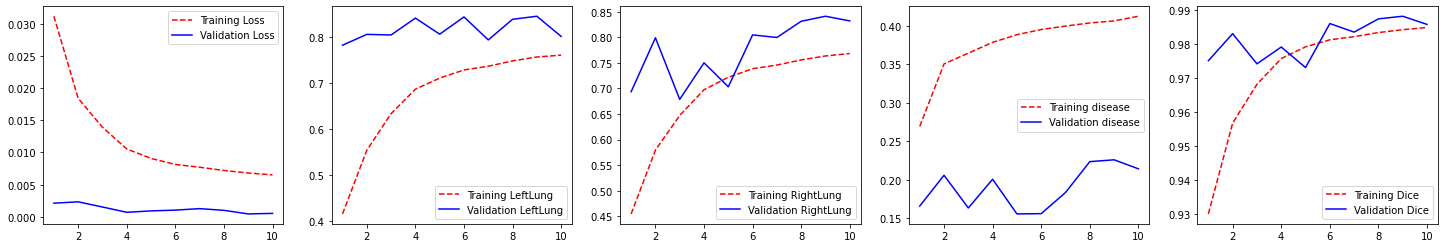

In [21]:
fig, axs = plt.subplots(1, 5, figsize = (25, 4))

training_loss = results.history['loss']
validation_loss = results.history['val_loss']

training_accuracy = results.history['fscore_leftlung']
validation_accuracy = results.history['val_fscore_leftlung']

training_accuracy2 = results.history['fscore_rightlung']
validation_accuracy2 = results.history['val_fscore_rightlung']

training_accuracy3 = results.history['fscore_disease']
validation_accuracy3 = results.history['val_fscore_disease']

training_accuracy4 = results.history['Dice_coef']
validation_accuracy4 = results.history['val_Dice_coef']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training LeftLung', 'Validation LeftLung'])

axs[2].plot(epoch_count, training_accuracy2, 'r--')
axs[2].plot(epoch_count, validation_accuracy2, 'b-')
axs[2].legend(['Training RightLung', 'Validation RightLung'])

axs[3].plot(epoch_count, training_accuracy3, 'r--')
axs[3].plot(epoch_count, validation_accuracy3, 'b-')
axs[3].legend(['Training disease', 'Validation disease'])

axs[4].plot(epoch_count, training_accuracy4, 'r--')
axs[4].plot(epoch_count, validation_accuracy4, 'b-')
axs[4].legend(['Training Dice', 'Validation Dice'])

# Load Model

In [22]:
model = keras.models.load_model('best_model_P.h5',custom_objects={
                                                'categorical_crossentropy': sm.losses.categorical_crossentropy,
                                                'fscore_background': fscore_background, 
                                                'fscore_leftlung': fscore_leftlung, 
                                                'fscore_rightlung': fscore_rightlung,
                                                'fscore_disease': fscore_disease,
                                                'Dice_coef': Dice_coef })

model.compile(Adam(learning_rate=0.001, amsgrad=True),
              loss=sm.losses.jaccard_loss)

In [23]:
input = valid_dataloader[7]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)

# Visualization

In [24]:
import matplotlib.pyplot as plt
import numpy as np


def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=10):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0])
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

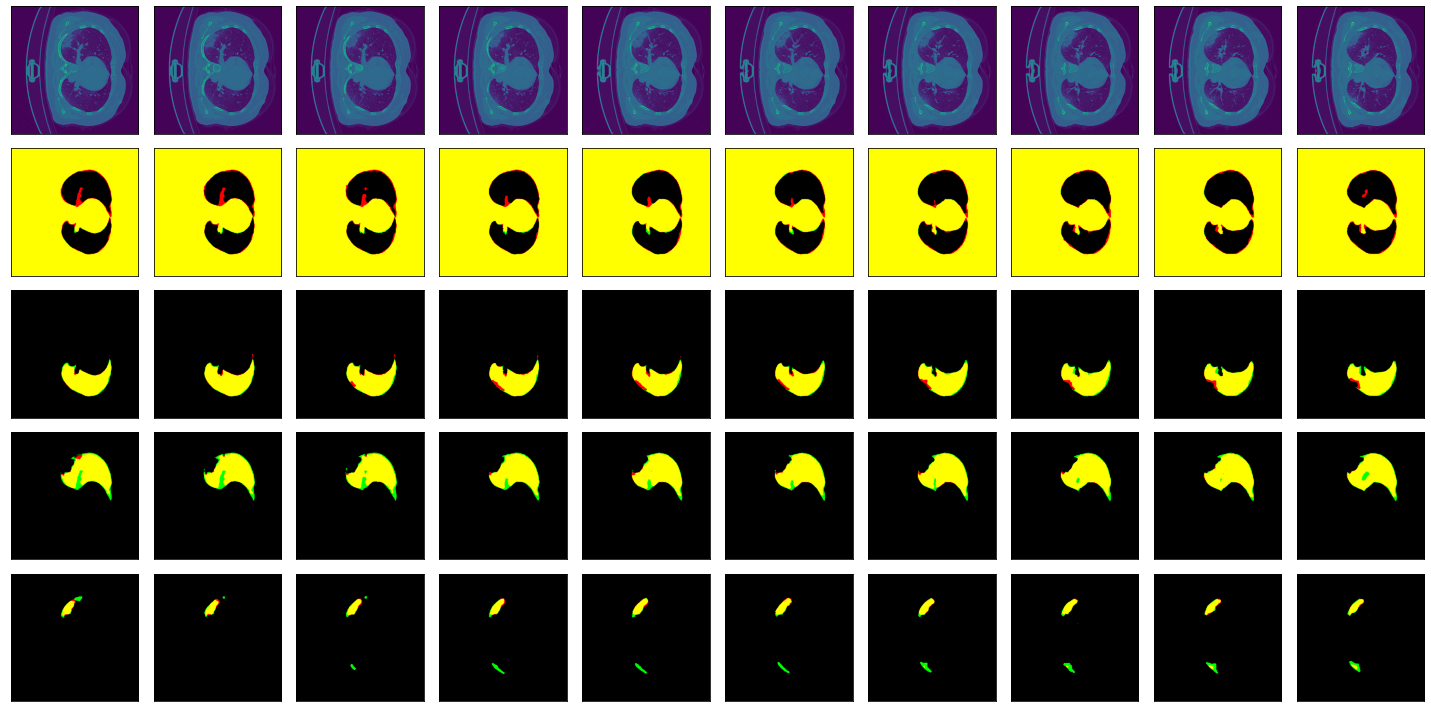

In [25]:
# yellow is TP, red is FP, green is FN
visualize(image_batch, mask_batch, pred_batch=preds)

#  Evaluative metrics for the model

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

def get_true_pos(ref, res, th=0.5):
    res = (res > 0.5)
    result = np.atleast_1d(res.astype(np.bool))
    reference = np.atleast_1d(ref.astype(np.bool))
    tp = np.count_nonzero(result & reference)
    return tp

def get_true_neg(ref, res, th=0.5):
    res = (res > th)
    result = np.atleast_1d(res.astype(np.bool))
    reference = np.atleast_1d(ref.astype(np.bool))
       
    tn = np.count_nonzero(~result & ~reference)
    return tn

def get_false_neg(ref, res, th=0.5):
    res = (res > th)
    result = np.atleast_1d(res.astype(np.bool))
    reference = np.atleast_1d(ref.astype(np.bool))
    fn = np.count_nonzero(~result & reference)
    return fn

def get_false_pos(ref, res, th=0.5):
    res = (res > th)
    result = np.atleast_1d(res.astype(np.bool))
    reference = np.atleast_1d(ref.astype(np.bool))
    fp = np.count_nonzero(result & ~reference)
    return fp

In [27]:
def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg,
                            acc=None, prevalence=None, spec=None,
                            sens=None, ppv=None, npv=None, auc=None, f1=None, Dice=None,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV","Dice", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = tp(y[...,i], pred[...,i])if tp != None else "Not Defined"
        df.loc[i][2] = tn(y[...,i], pred[...,i])if tn != None else "Not Defined"
        df.loc[i][3] = fp(y[...,i], pred[...,i])if fp != None else "Not Defined"
        df.loc[i][4] = fn(y[...,i], pred[...,i])if fn != None else "Not Defined"
        df.loc[i][5] = acc(y[...,i], pred[...,i], thresholds[i])if acc != None else "Not Defined"
        df.loc[i][6] = prevalence(y[...,i])if prevalence != None else "Not Defined"
        df.loc[i][7] = sens(y[...,i], pred[...,i], thresholds[i]) if sens != None else "Not Defined"
        df.loc[i][8] = spec(y[...,i], pred[...,i], thresholds[i]) if spec != None else "Not Defined"
        df.loc[i][9] = ppv(y[...,i], pred[...,i], thresholds[i]) if ppv != None else "Not Defined"
        df.loc[i][10] = npv(y[...,i], pred[...,i], thresholds[i]) if npv != None else "Not Defined"
        df.loc[i][11] = Dice(y[...,i], pred[...,i]) if Dice != None else "Not Defined"                      
        df.loc[i][12] = round(thresholds[i], 3)

    df = df.set_index("")
    return df

# Accuracy

In [28]:
def get_accuracy(y, pred, th=0.5):
    accuracy = 0.0
    TP = get_true_pos(y, pred, th)
    FP = get_false_pos(y, pred, th)
    TN = get_true_neg(y, pred, th)
    FN = get_false_neg(y, pred, th)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    return (accuracy * 100)

# Prevalence

In [29]:
def get_prevalence(y):
    prevalence = 0.0

    prevalence = np.mean(y)

    return (prevalence * 100)

# Sensitivity

In [30]:
def get_sensitivity(y, pred, th=0.5):
    sensitivity = 0.0
    
    TP = get_true_pos(y, pred, th)
    FN = get_false_neg(y, pred, th)

    sensitivity = TP / (TP + FN)

    return (sensitivity * 100)

# Specificity

In [31]:
def get_specificity(y, pred, th=0.5):
    specificity = 0.0

    TN = get_true_neg(y, pred, th)
    FP = get_false_pos(y, pred, th)
 
    specificity = TN / (TN + FP)

    return (specificity * 100)

# Positive predictive value (PPV) 

In [32]:
def get_ppv(y, pred, th=0.5):
    PPV = 0.0

    TP = get_true_pos(y, pred, th)
    FP = get_false_pos(y, pred, th)

    PPV = TP / (TP + FP)
    
    return (PPV * 100)

# Negative predictive value (NPV)

In [33]:
def get_npv(y, pred, th=0.5):
    NPV = 0.0

    TN = get_true_neg(y, pred, th)
    FN = get_false_neg(y, pred, th)

    NPV = TN / (TN + FN)

    return (NPV * 100)

# Dice Coefficient

In [34]:
def get_dice(y, pred):
  TP=FPN=0
  TP = np.sum(pred*y)
  FPN = np.sum(pred)+np.sum(y)
        
  dice = 2*TP/FPN
  return (dice * 100)

In [35]:
class_labels = ['RightLung','LeftLung','Disease']
get_performance_metrics(mask_batch, preds, class_labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, Dice=get_dice)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,Dice,Threshold
,,,,,,,,,,,,
RightLung,2002388,323843,30813,2252,98.5985,84.9677,99.8877,91.3119,98.4845,99.3094,98.889,0.5
LeftLung,133180,2210674,5194,10248,99.3455,6.07927,92.855,99.7656,96.2464,99.5386,92.0179,0.5
Disease,164429,2171278,1428,22161,99.0002,7.90872,88.1232,99.9343,99.139,98.9897,91.6287,0.5


# ROC Curve

In [36]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
import glob
from PIL import Image
import skimage
import numpy
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import disk
from sklearn.metrics import confusion_matrix
from skimage.measure import label, regionprops
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import jaccard_similarity_score
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score

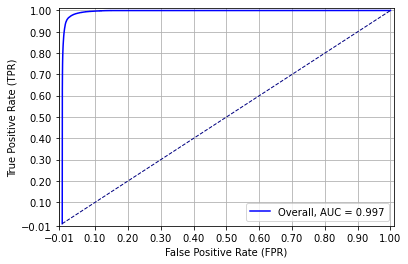

In [37]:
flattenGT=mask_batch[...,3].ravel()

flattenPD=preds[...,3].ravel()

fpr_f1, tpr_f1, thresholds_fcn = roc_curve(flattenGT,
                                             flattenPD)

auc_f= roc_auc_score(flattenGT,
                        flattenPD)


# plot perfromance for binary segemnatation
lw = 1
plt.grid(True)
plt.plot(fpr_f1, tpr_f1,'-b',label='Overall, AUC = '+str(round(auc_f,3)))
axisRange = [-0.01, 0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([0.0, 1.01])
plt.xticks(axisRange)
plt.yticks(axisRange)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

# Hausdoff Distance

In [38]:
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion,generate_binary_structure
def __surface_distances(result, reference, voxelspacing=None, connectivity=1):
    result = numpy.atleast_1d(result.astype(numpy.bool))
    reference = numpy.atleast_1d(reference.astype(numpy.bool))
    if voxelspacing is not None:
        voxelspacing = _ni_support._normalize_sequence(voxelspacing, result.ndim)
        voxelspacing = numpy.asarray(voxelspacing, dtype=numpy.float64)
        if not voxelspacing.flags.contiguous:
            voxelspacing = voxelspacing.copy()
            
    # binary structure
    footprint = generate_binary_structure(result.ndim, connectivity)
    
    # test for emptiness
    if 0 == numpy.count_nonzero(result): 
        raise RuntimeError('The first supplied array does not contain any binary object.')
    if 0 == numpy.count_nonzero(reference): 
        raise RuntimeError('The second supplied array does not contain any binary object.')    
            
    # extract only 1-pixel border line of objects
    result_border = result ^ binary_erosion(result, structure=footprint, iterations=1)
    reference_border = reference ^ binary_erosion(reference, structure=footprint, iterations=1)
    
    # compute average surface distance        
    # Note: scipys distance transform is calculated only inside the borders of the
    #       foreground objects, therefore the input has to be reversed
    dt = distance_transform_edt(~reference_border, sampling=voxelspacing)
    sds = dt[result_border]
    
    return sds

def hd(result, reference, voxelspacing=None, connectivity=1):
    hd1 = __surface_distances(result, reference, voxelspacing, connectivity).max()
    hd2 = __surface_distances(reference, result, voxelspacing, connectivity).max()
    hd = max(hd1, hd2)
    return hd

def hd95(result, reference, voxelspacing=None, connectivity=1):
    hd1 = __surface_distances(result, reference, voxelspacing, connectivity)
    hd2 = __surface_distances(reference, result, voxelspacing, connectivity)
    hd95 = numpy.percentile(numpy.hstack((hd1, hd2)), 95)
    return hd95

In [39]:
ct_array = mask_batch[15][...,2] 
seg_array= preds[15][...,2]

In [40]:
HD9511=hd95(ct_array,seg_array)
print(HD9511/16)

15.2153807872166


In [41]:
HD11=hd(ct_array,seg_array)
print(HD11/16)

17.237540790379583


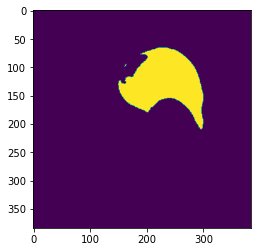

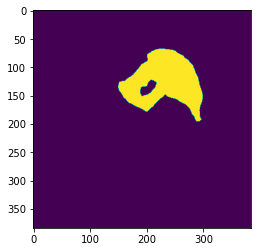

In [42]:
plt.imshow(mask_batch[10][...,2])
plt.show()
plt.imshow(preds[10][...,2]> 0.5)
plt.show()

# Bland-Altman Plot

In [43]:
def get_vector_area_pre(pred):
    area_left=[]
    area_right=[]
    disease =[]
    for pre in pred:
        ret,thresh1 = cv2.threshold(pre[...,1] ,0.5,1,cv2.THRESH_BINARY)
        area1 = cv2.countNonZero(thresh1) /(256*256)
        area_left.append(area1)
        ret,thresh2 = cv2.threshold(pre[...,2] ,0.5,1,cv2.THRESH_BINARY)
        area2 = cv2.countNonZero(thresh1)/(256*256)
        area_right.append(area2)
        ret,thresh3 = cv2.threshold(pre[...,3] ,0.5,1,cv2.THRESH_BINARY)
        area3 = cv2.countNonZero(thresh1)/(256*256)
        disease.append(area3)
    return area_left, area_right, disease

In [44]:
area_left, area_right, disease = get_vector_area_pre(preds)
print(len(area_left), len(area_right), len(disease))

16 16 16


In [45]:
def get_vector_area_g(gt):
    area_left=[]
    area_right=[]
    disease =[]
    for g in gt:
        area1 = cv2.countNonZero(g[...,1])/(256*256)
        area_left.append(area1)
        area2 = cv2.countNonZero(g[...,2])/(256*256)
        area_right.append(area2)
        area3 = cv2.countNonZero(g[...,3])/(256*256)
        disease.append(area3)
    return area_left, area_right, disease

In [46]:
area_left1, area_right1, disease1 = get_vector_area_g(mask_batch)
print(len(area_left1), len(area_right1), len(disease1))

16 16 16


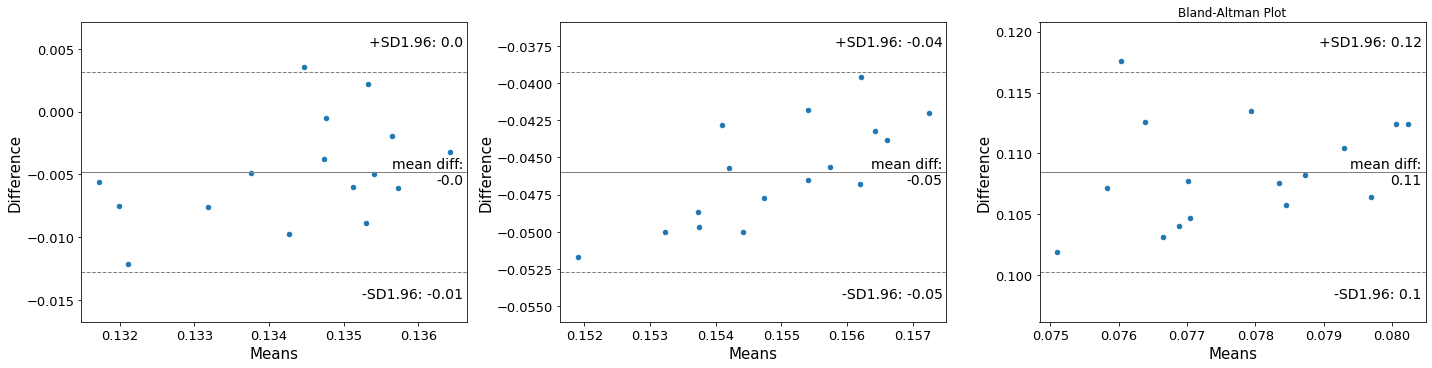

In [47]:
import statsmodels.api as sm
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
sm.graphics.mean_diff_plot(np.asarray(area_left), np.asarray(area_left1), ax = axs[0])
sm.graphics.mean_diff_plot(np.asarray(area_right), np.asarray(area_right1), ax = axs[1])
sm.graphics.mean_diff_plot(np.asarray(disease), np.asarray(disease1), ax = axs[2])
plt.title('Bland-Altman Plot')
plt.show()